In [2]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
# generate dataset
mu = np.array([50, 80, 100])
sd = np.array([3, 5, 10])

n_samples = np.array([100, 150, 100])
factor_levels = np.array(['A', 'B', 'C'])

data = pd.DataFrame(data={
    'y':np.concatenate(
        (np.random.normal(loc=mu[0], scale=sd[0], size=n_samples[0]), 
         np.random.normal(loc=mu[1], scale=sd[1], size=n_samples[1]), 
         np.random.normal(loc=mu[2], scale=sd[2], size=n_samples[2]))
    ),
    'x':np.repeat(factor_levels, n_samples)
})

data.x = pd.Categorical(data.x, ordered=False)

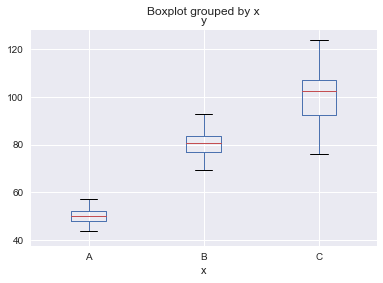

In [10]:
_ = data.boxplot(column='y', by='x')

In [12]:
# design matrix. Treatment (Dummy) Coding (see: https://onlinecourses.science.psu.edu/stat502/node/246)
_, X = patsy.dmatrices('y ~ 1 + x', data=data)
X = np.asarray(X)
X

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.]])

In [13]:
with pm.Model() as ANOVA_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(X.shape[1]))
    
    mu = pm.math.dot(X, beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the ampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=2000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


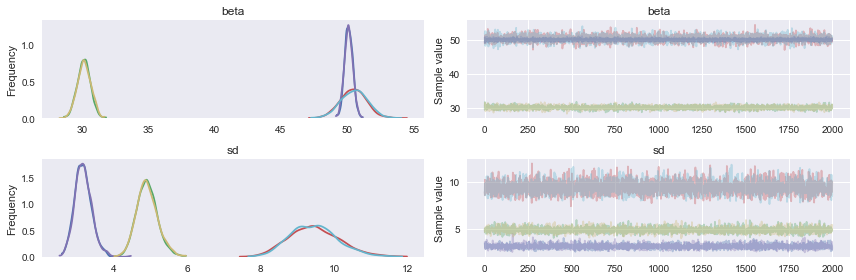

In [14]:
_ = pm.traceplot(trace)

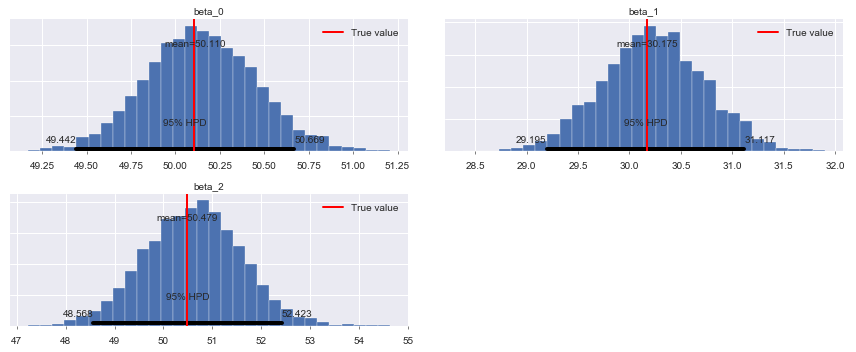

In [43]:
ax = pm.plot_posterior(trace, ['beta'])

ax[0].axvline(grouped.loc['A'].values, color='red', lw=2, label='True value')
ax[1].axvline(grouped.loc['B'].values - grouped.loc['A'].values, color='red', lw=2, label='True value')
ax[2].axvline(grouped.loc['C'].values - grouped.loc['A'].values, color='red', lw=2, label='True value')

ax[0].legend()
ax[1].legend()
ax[2].legend()

pass

In [55]:
# design matrix. ´Effects model´ . The intercept is the grand mean, whereas the slope is the deviations of the factors levels
_, X = patsy.dmatrices('y ~ 0 + C(x, Sum)', data=data)
X = np.asarray(X)

In [46]:
with pm.Model() as ANOVA_sum_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(X.shape[1]))
    
    mu = pm.math.dot(X, beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the ampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=2000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


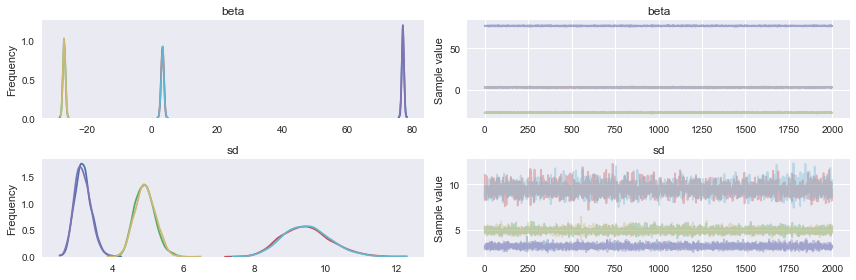

In [47]:
_ = pm.traceplot(trace)

In [63]:
# add deviation of C
beta_3 = - trace['beta'][:, 1] - trace['beta'][:, 2]
trace.add_values({'beta_3':beta_3})

Grand mean = [76.98956842]
Levels mean = 
            y
x            
A   50.106975
B   80.282699
C  100.579030


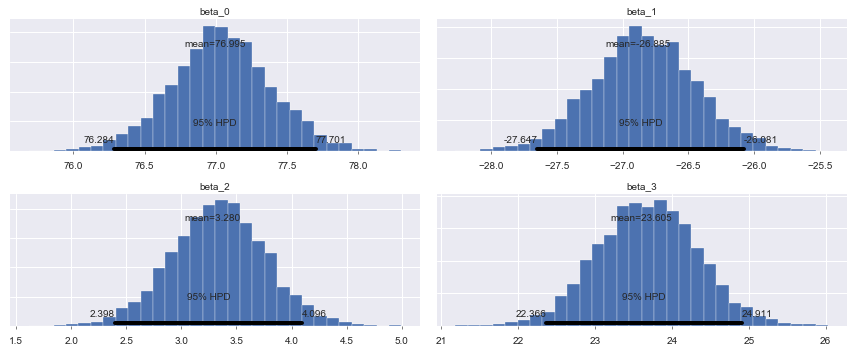

In [68]:
print('Grand mean = {}'.format(data.groupby(by='x').mean().mean().values))
print('Levels mean = ')
print(data.groupby(by='x').mean())

_ = pm.plot_posterior(trace, ['beta', 'beta_3'])

In [61]:

_, X = patsy.dmatrices('y ~ 0 + C(x, Sum)', data=data)
X.design_info

DesignInfo(['C(x, Sum)[mean]', 'C(x, Sum)[S.A]', 'C(x, Sum)[S.B]'],
           factor_infos={EvalFactor('C(x, Sum)'): FactorInfo(factor=EvalFactor('C(x, Sum)'),
                                    type='categorical',
                                    state=<factor state>,
                                    categories=('A', 'B', 'C'))},
           term_codings=OrderedDict([(Term([EvalFactor('C(x, Sum)')]),
                                      [SubtermInfo(factors=(EvalFactor('C(x, Sum)'),),
                                                   contrast_matrices={EvalFactor('C(x, Sum)'): ContrastMatrix(array([[ 1.,  1.,  0.],
                                                                                            [ 1.,  0.,  1.],
                                                                                            [ 1., -1., -1.]]),
                                                                                     ['[mean]',
                                                   